In [113]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import time
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor
import warnings
warnings.filterwarnings("ignore")
import torchmetrics

In [4]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return (Y)

x = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
k = torch.tensor([[0, 1], [2, 3]])

print (x, x.shape)
print (k, k.shape)

print (corr2d(x, k))

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]) torch.Size([3, 3])
tensor([[0, 1],
        [2, 3]]) torch.Size([2, 2])
tensor([[19., 25.],
        [37., 43.]])


In [5]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return (Y)

class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return (corr2d(x, self.weight) + self.bias)


In [6]:
X = torch.ones((6, 8))
X[:,  2:6] = 0
print (X, X.shape)

# K representing finite difference operator: edge detection
K = torch.tensor([[1.0, -1.0]])
print (K, K.shape)

Y = corr2d(X, K)

print (Y, Y.shape)

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]]) torch.Size([6, 8])
tensor([[ 1., -1.]]) torch.Size([1, 2])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]) torch.Size([6, 7])


In [7]:
corr2d(X.T, K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [44]:
conv2D = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))

print('Original X:')
print(X, X.shape)

print('Original Y to fit:')
Y = Y.reshape([1, 1, 6, 7])
print(Y, Y.shape)

print('Example of Conv2D:')
Z = conv2D(X)
print(Z, Z.shape)


Original X:
tensor([[[[1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.]]]]) torch.Size([1, 1, 6, 8])
Original Y to fit:
tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]]) torch.Size([1, 1, 6, 7])
Example of Conv2D:
tensor([[[[ 0.0917, -0.3280,  0.0000,  0.0000,  0.0000,  0.4197,  0.0917],
          [ 0.0917, -0.3280,  0.0000,  0.0000,  0.0000,  0.4197,  0.0917],
          [ 0.0917, -0.3280,  0.0000,  0.0000,  0.0000,  0.4197,  0.0917],
          [ 0.0917, -0.3280,  0.0000,  0.0000,  0.0000,  0.4197,  0.0917],
          [ 0.0917, -0.3280,  0.0000,  0.0000,  

/Users/jsmidt/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [45]:
lr = 0.03
for i in range(12):
    Y_hat = conv2D(X)
    l = ((Y_hat - Y)**2).sum()
    conv2D.zero_grad()
    l.backward()
    #print(conv2D.weight.grad)
    conv2D.weight.data[:] -= lr * conv2D.weight.grad
    if (i+1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.item():.3f}')

epoch 2, loss 9.358
epoch 4, loss 1.589
epoch 6, loss 0.275
epoch 8, loss 0.049
epoch 10, loss 0.010
epoch 12, loss 0.002


In [48]:
print (conv2D.weight.data.view(2))
print (Y)
print (Y_hat)

tensor([ 0.9967, -0.9904])
tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]])
tensor([[[[-0.0079,  0.9859,  0.0000,  0.0000,  0.0000, -0.9938, -0.0079],
          [-0.0079,  0.9859,  0.0000,  0.0000,  0.0000, -0.9938, -0.0079],
          [-0.0079,  0.9859,  0.0000,  0.0000,  0.0000, -0.9938, -0.0079],
          [-0.0079,  0.9859,  0.0000,  0.0000,  0.0000, -0.9938, -0.0079],
          [-0.0079,  0.9859,  0.0000,  0.0000,  0.0000, -0.9938, -0.0079],
          [-0.0079,  0.9859,  0.0000,  0.0000,  0.0000, -0.9938, -0.0079]]]],
       grad_fn=<ConvolutionBackward0>)


In [75]:
X = torch.zeros((6,8))

X[1:6,0:8].fill_diagonal_(1.0)
X[0:6,0:8].fill_diagonal_(1.0)
X[2:6,0:8].fill_diagonal_(1.0)

X

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0.]])

In [78]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return (Y)


# K representing finite difference operator: edge detection
K = torch.tensor([[1.0, -1.0]])
print (K, K.shape)

print ("Normal X")
Y = corr2d(X, K)
print (Y)

print ("Transpose X")
Y = corr2d(X.T, K)
print (Y)

print ("Transpose K")
Y = corr2d(X, K.T)
print (Y)

tensor([[ 1., -1.]]) torch.Size([1, 2])
Normal X
tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  1.,  0.]])
Transpose X
tensor([[ 0.,  0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
Transpose K
tensor([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0., -1.,  0.,  0.]])


In [22]:
def comp_conv2d(conv2D, X):
    X = X.reshape((1,1) + X.shape)
    Y = conv2D(X)
    return Y.reshape(Y.shape[2:])

conv2D = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand((8,8))
print (X.shape)
Y = comp_conv2d(conv2D, X)

print (Y, Y.shape)


torch.Size([8, 8])
tensor([[ 0.2249,  0.0190, -0.0297,  0.3708,  0.1563,  0.1599, -0.1715, -0.0242],
        [ 0.1242, -0.1107, -0.0125, -0.2845, -0.1606, -0.2476, -0.3285, -0.2991],
        [ 0.2812, -0.2579, -0.2680, -0.3600, -0.0043, -0.0227,  0.0208, -0.3025],
        [-0.1561, -0.2783,  0.0342,  0.1681,  0.3364, -0.0629, -0.2515, -0.3790],
        [-0.0200,  0.3406,  0.0017, -0.1172, -0.3205, -0.2876, -0.5326, -0.3680],
        [ 0.1894, -0.3008, -0.3717, -0.4712, -0.3533, -0.2045, -0.1415, -0.2119],
        [-0.0662, -0.2230, -0.1037,  0.0741, -0.1633,  0.0549,  0.0603,  0.0845],
        [-0.3636, -0.2313, -0.0654, -0.3774, -0.1489, -0.2385, -0.0418, -0.4194]],
       grad_fn=<ReshapeAliasBackward0>) torch.Size([8, 8])


In [39]:
conv2D = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)

Y = comp_conv2d(conv2D, X)

print (Y, Y.shape)

tensor([[0.4322, 0.5679, 0.2444, 0.4230],
        [0.5999, 0.8545, 0.8634, 0.9430],
        [0.6543, 0.3259, 0.5415, 0.6712],
        [0.5548, 0.7564, 0.3921, 0.4204]], grad_fn=<ReshapeAliasBackward0>) torch.Size([4, 4])


In [43]:
conv2D = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2D, X)


/Users/jsmidt/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Parameter containing:
tensor([[[[-0.1666,  0.0273, -0.1168,  0.1210,  0.0513],
          [-0.1438, -0.0706,  0.2099,  0.1201, -0.0334],
          [ 0.2075,  0.1467,  0.1505, -0.0046,  0.0119]]]], requires_grad=True)

In [80]:
def comp_conv2d(conv2D, X):
    X = X.reshape((1,) + X.shape)
    Y = conv2D(X)
    return Y.reshape(Y.shape[1:])


conv2D = nn.LazyConv2d(3, kernel_size=1)
X = torch.rand((3, 3, 3))
print(X,X.shape)
Y = comp_conv2d(conv2D, X)
print(Y, Y.shape)


tensor([[[0.3447, 0.1833, 0.0658],
         [0.8468, 0.2135, 0.4940],
         [0.7293, 0.5813, 0.0133]],

        [[0.6210, 0.2011, 0.8367],
         [0.0631, 0.6373, 0.0665],
         [0.2933, 0.5737, 0.5621]],

        [[0.8011, 0.2778, 0.6255],
         [0.4148, 0.5092, 0.2928],
         [0.5838, 0.8066, 0.2257]]]) torch.Size([3, 3, 3])
tensor([[[ 0.2678,  0.2477,  0.1635],
         [ 0.4945,  0.2316,  0.3682],
         [ 0.4340,  0.3577,  0.1728]],

        [[-0.4817, -0.3961, -0.5909],
         [-0.2504, -0.5127, -0.3087],
         [-0.3317, -0.4312, -0.5278]],

        [[ 0.3482,  0.3519,  0.4249],
         [ 0.2654,  0.3950,  0.3056],
         [ 0.2920,  0.3228,  0.4304]]], grad_fn=<ReshapeAliasBackward0>) torch.Size([3, 3, 3])


In [74]:
Y.shape[1:]

torch.Size([2, 3, 3])

In [55]:
(1,) + X.shape

(1, 2, 2, 2)

In [87]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i+p_h, j: j+p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i:i+p_h, j: j+p_w].mean()

    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])

X = torch.arange(9).view(3,3).float()

print (X)

print (pool2d(X, (2,2)))
print (pool2d(X, (2,2), mode='avg'))

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
tensor([[4., 5.],
        [7., 8.]])
tensor([[2., 3.],
        [5., 6.]])


In [89]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))

pool2d = nn.MaxPool2d(3)

pool2d(X)

tensor([[[[10.]]]])

In [91]:
pool2d = nn.MaxPool2d((2,3), padding=(0,1), stride=(2,3))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [92]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [93]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

In [94]:
# Random pooling can improve accuracy in some cases. 

In [81]:
X = X = torch.randn((28,28), dtype=torch.float32).reshape((1, 1, 28, 28))
X.shape

In [104]:
step1 = nn.LazyConv2d(6, kernel_size=5, padding=2)
step2 = nn.AvgPool2d(kernel_size=2, stride=2)
step3 = nn.LazyConv2d(16, kernel_size=5)
step4 = nn.AvgPool2d(kernel_size=2, stride=2)
step5 = nn.Flatten()

/Users/jsmidt/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [107]:
X                # (1,1,28,28) Image
Y = step1(X)     # nn.LazyConv2d(6, kernel_size=5, padding=2)
print (Y.shape)  # (1, 6, 28, 28) Image
Y = step2(Y)     # nn.AvgPool2d(kernel_size=2, stride=2)
print (Y.shape)  # Reduces by factor of 2: (1, 6, 14, 14) Image
Y = step3(Y)     # nn.LazyConv2d(16, kernel_size=5)
print (Y.shape)  # Redoces to (1, 16, 10, 10) image
Y = step4(Y)     # nn.AvgPool2d(kernel_size=2, stride=2)
print (Y.shape)  # Redoces to (1, 16, 5, 5) image
Y = step5(Y)     # nn.Flatten()
print (Y.shape)


torch.Size([1, 6, 28, 28])
torch.Size([1, 6, 14, 14])
torch.Size([1, 16, 10, 10])
torch.Size([1, 16, 5, 5])
torch.Size([1, 400])


In [105]:
16*5*5

400

In [149]:

def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        #nn.init.xavier_uniform_(module.weight)
        nn.init.kaiming_uniform_(module.weight, a=2.0**0.5)

class LeNet(nn.Module):  #@save
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

    def forward(self, x):
        out = self.model(x)
        return out

    def accuracy(self, Y_hat, y):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).long()
        compare = (preds == y).float()
        return compare.mean()

In [136]:
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
print (model)

LeNet(
  (model): Sequential(
    (0): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=120, bias=True)
    (8): ReLU()
    (9): LazyLinear(in_features=0, out_features=84, bias=True)
    (10): ReLU()
    (11): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)


In [140]:
# Import Datasets
class FashionMNIST:
    def __init__(self) -> None:
        # Get datasets
        self.train = datasets.FashionMNIST(root='data', train=True, transform=ToTensor())
        self.val = datasets.FashionMNIST(root='data', train=False, transform=ToTensor())

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = 1024, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = 1024, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 59, 10)

In [150]:
max_epochs = 50

model = LeNet()
model.model(next(iter(data.train_dl))[0])  
model.apply(init_cnn)

# model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
for epoch in range(1, max_epochs+1):
    for batch in data.train_dl:
        x, y = batch
        logits = model(x)

        train_loss = torch.nn.functional.cross_entropy(logits, y)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    with torch.no_grad():
        for batch in data.val_dl:
            x, y = batch
            logits = model(x)
            acc = model.accuracy(logits, y)
            break

    if epoch % 5 == 0:
        print(f'Epoch {epoch:>2d} with training loss {train_loss.item():.4f} and accuracy {acc:.4f}')


Epoch  5 with training loss 0.6637 and accuracy 0.7334


KeyboardInterrupt: 

In [147]:
model = LeNet()
model.model(next(iter(data.train_dl))[0])  
model.apply(init_cnn)

#model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)


LeNet(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [160]:
torch.manual_seed(42)
n_embd = 10
n_hidden = 200
batch_size = 1024


class Classifier3(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(), nn.Linear(784,10))
        self.batch_size = 1024
        self.learning_rate = 0.014
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.model(next(iter(data.train_dl))[0])  
        self.apply(init_cnn)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        self.train_acc(logits, y)
        self.log("train_loss", loss, prog_bar=False,
                 on_step=False, on_epoch=True)
        self.log('train_acc', self.train_acc, prog_bar=True,
                 on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        # self.log('train_loss', loss)
        self.log("val_loss", loss, prog_bar=True,
                 on_step=False, on_epoch=True)
        
        return loss

    def predict_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # x, y = batch
        x = batch
        # x = x.view(x.size(0), -1)
        logits = self.model(x)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=10) 
        lr_scheduler = {"scheduler": scheduler, "interval": "epoch", "monitor": "val_loss"}
        return [optimizer], [lr_scheduler]

    def init_cnn(module):  #@save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            nn.init.kaiming_uniform_(module.weight, a=2.0**0.5)


model = Classifier3()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /Users/jsmidt/Documents/AI/scratch/d2l/.lr_find_d52d6531-90f1-42fe-a5b5-f7358c36dbcf.ckpt
Restored all states from the checkpoint file at /Users/jsmidt/Documents/AI/scratch/d2l/.lr_find_d52d6531-90f1-42fe-a5b5-f7358c36dbcf.ckpt


0.01445439770745928


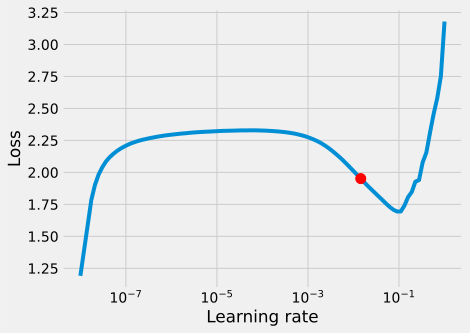

In [159]:
# run learning rate finder, results override hparams.learning_rate
trainer = pl.Trainer(auto_lr_find=True)

# call tune to find the lr
#lr_finder = trainer.tune(makemore, train_dataloaders=data)
lr_finder = trainer.tuner.lr_find(model, train_dataloaders=data.train_dl)

# Results can be found in
#print(lr_finder.results)
print (lr_finder.suggestion())

fig = lr_finder.plot(suggest=True)
fig.show()

In [161]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(max_epochs=100, accelerator="cpu", callbacks=[TQDMProgressBar(refresh_rate=400),lr_monitor])
trainer.fit(model=model, train_dataloaders=data.train_dl, val_dataloaders=data.val_dl)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | Sequential         | 7.9 K 
1 | train_acc | MulticlassAccuracy | 0     
-------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
